## CA 2, LLMs Spring 2024

- **Name:** ***Pouya Sadeghi***
- **Student ID:** ***810199447***

---
#### Your submission should be named using the following format: `CA2_LASTNAME_STUDENTID_gpt.ipynb`.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TA via email:
sepehr.kamahi@ut.ac.ir

---

**Colab notebook link:** https://drive.google.com/file/d/1AxaKeJusFl8cmXQjIrODAo_pot_TaqN3/view?usp=sharing

---

## Section 1: Generate a Single Sentence (20 points)
Write a prompt that has ten tokens according to the GPT-2 tokenizer. (2 points)

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import time
model_name = "gpt2"

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
# prompt = "I am studying computer science at the University of Tehran"
prompt = "Once upon a time, there was a student who"
## print the tokens, input_ids, and attention_mask
tokens = tokenizer(prompt, return_tensors="pt")
tokens_str = tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze())

print(f"""\
Prompt        : {prompt}
Tokens        : {tokens_str}
input_ids     : {tokens["input_ids"]}
Attention Mask: {tokens["attention_mask"]}
Prompt length : {len(tokens_str)} (tokens)\
""")

Prompt        : Once upon a time, there was a student who
Tokens        : ['Once', 'Ġupon', 'Ġa', 'Ġtime', ',', 'Ġthere', 'Ġwas', 'Ġa', 'Ġstudent', 'Ġwho']
input_ids     : tensor([[7454, 2402,  257,  640,   11,  612,  373,  257, 3710,  508]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Prompt length : 10 (tokens)


### a) Load the model to the GPU
Use the prompt you wrote and generate 190 new tokens, appending each new token to the previous sequence at each step. Measure the time of generating each new token. You CAN ONLY use PyTorch for decoding; use greedy decoding. You will get a 200-token sequence at the end, so print the sentence.

Plot the time needed for generating each new token. Use torch.cuda.max_memory_allocated and plot the memory used at each step in MB. At each step, by giving the input_ids to the model as the labels argument, the loss will be calculated for you automatically. Plot the loss at all steps.

Explain the patterns you see in the plots. (8 points)

**Attention: We try to generate a sequence of len 200 tokens in later expariments to mach with input length of this experiment.**

In [ ]:
assert torch.cuda.is_available(), "CUDA is not available, move to GPU!"
model = model.to("cuda")
tokens = tokenizer(prompt, return_tensors="pt").to("cuda")

time_taken = []
memory_used = []
losses = []

start_step = len(tokens["input_ids"][0,:])

with torch.no_grad():
    for i in range(190):
        start = time.time()
        outputs = model(**tokens, labels=tokens["input_ids"])
        end = time.time()

        loss = outputs.loss
        mem_aloc = torch.cuda.max_memory_allocated()

        next_token_logits = outputs.logits[:, -1, :]
        next_token = next_token_logits.argmax(-1)
        tokens["input_ids"] = torch.cat([tokens["input_ids"], next_token.unsqueeze(-1)], dim=-1)
        tokens["attention_mask"] = torch.cat([tokens["attention_mask"], torch.ones((1, 1), device="cuda")], dim=-1)

        losses.append(loss.item())
        time_taken.append((end - start) * 1e3)
        memory_used.append(mem_aloc / 1024 / 1024)

        token_str = tokenizer.decode(tokens['input_ids'].squeeze()[-1:])
        presenting_token_str = '\\n' if token_str == '\n' else token_str

        print(f"(Step {start_step+i+1:>3})  \
        Token: {presenting_token_str:<20}, \
        Loss: {loss.item():.4f}, \
        Time: {time_taken[-1]:.4f}, \
        Memory: {memory_used[-1]:.3f} MB")

        if next_token.item() == tokenizer.eos_token_id:
            print(f"Breaking the iteration at {i+1} token")
            break

print(f"Generated sentence: {tokenizer.decode(tokens['input_ids'].squeeze())}")

(Step  11)          Token:  was                ,         Loss: 2.9494,         Time: 4588.0208,         Memory: 501.305 MB
(Step  12)          Token:  a                  ,         Loss: 2.8376,         Time: 24.4408,         Memory: 504.578 MB
(Step  13)          Token:  student            ,         Loss: 2.8664,         Time: 17.0472,         Memory: 505.201 MB
(Step  14)          Token:  of                 ,         Loss: 2.8635,         Time: 50.7448,         Memory: 505.991 MB
(Step  15)          Token:  the                ,         Loss: 2.7319,         Time: 17.1773,         Memory: 510.347 MB
(Step  16)          Token:  same               ,         Loss: 2.6617,         Time: 19.9587,         Memory: 511.136 MB
(Step  17)          Token:  name               ,         Loss: 2.6593,         Time: 36.2344,         Memory: 512.572 MB
(Step  18)          Token: ,                   ,         Loss: 2.5961,         Time: 18.9080,         Memory: 512.978 MB
(Step  19)          Token:  an

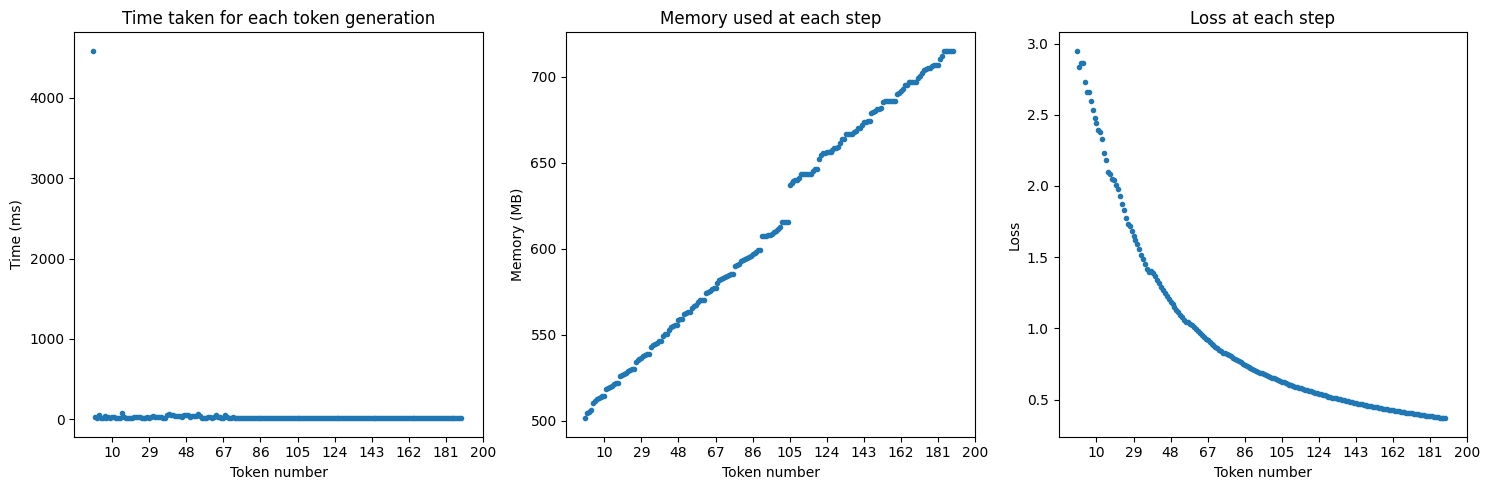

In [ ]:
# Plot the time needed for generating each new token, max_memory_allocated and loss.
# Consider x-axis to be from 11 to 200
x = range(start_step, start_step + len(time_taken)+1, len(time_taken)//10)
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(time_taken, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Time taken for each token generation")
plt.xlabel("Token number")
plt.ylabel("Time (ms)")

ax = plt.subplot(1, 3, 2)
plt.plot(memory_used, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Memory used at each step")
plt.xlabel("Token number")
plt.ylabel("Memory (MB)")

ax = plt.subplot(1, 3, 3)
plt.plot(losses, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Loss at each step")
plt.xlabel("Token number")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

**Explaining Plots**:

- ***Memory Usage***: In general, we can see that memory usage increases as we generate more tokens. This is expected because the model needs to store more information as it generates more tokens. The memory usage increases almost linearly with the number of tokens generated. For generating each new token, the model has to process and store more information about the previous context, also, it needs more iteration to each the place of the new token that is wants to generate.
- ***Time Taken***: The time taken for generating each new token is relatively constant. This is because the model processes each token independently and doesn't have to consider the entire sequence when generating a new token.(I'm not sure about this)
- ***Loss***: As we can see, the loss decreases as we generate more tokens. This is because the model is trained to minimize the loss, and as it generates more tokens, it gets better at predicting the next token in the sequence, as it has more context to infer the task.

### b) Use past_key_values
Give the past_key_values to the model during generation, and repeat all of the above steps; then, compare the results. (10 points)

In [4]:
torch.cuda.empty_cache()

model = model.to("cuda")
tokens = tokenizer(prompt, return_tensors="pt").to("cuda")
torch.cuda.empty_cache()

time_taken_b = []
memory_used_b = []
through_b = []

start_step = len(tokens["input_ids"][0,:])
all_tokens = tokens["input_ids"]

with torch.no_grad():
    past_key_values = None
    for i in range(200-start_step):
        # context_ids = tokens["input_ids"][:, :-1]
        # next_word_ids = tokens["input_ids"][:, -1:]

        start = time.time()
        outputs = model(**tokens, past_key_values=past_key_values)
        end = time.time()

        mem_aloc = torch.cuda.max_memory_allocated()

        next_token_logits = outputs.logits[:, -1, :]
        next_token = next_token_logits.argmax(-1)
        # tokens["input_ids"] = torch.cat([tokens["input_ids"], next_token.unsqueeze(-1)], dim=-1)
        # tokens["attention_mask"] = torch.cat([tokens["attention_mask"], torch.ones((1, 1), device="cuda")], dim=-1)
        tokens["input_ids"] = next_token.unsqueeze(-1)
        tokens["attention_mask"] = torch.ones((1, 1), device="cuda")
        all_tokens = torch.cat([all_tokens, next_token.unsqueeze(-1)], dim=-1)

        past_key_values = outputs.past_key_values

        time_taken_b.append((end - start) * 1e3)
        through_b.append(1/(end - start))
        memory_used_b.append(mem_aloc / 1024 / 1024)

        token_str = tokenizer.decode(all_tokens.squeeze()[-1:])
        presenting_token_str = '\\n' if token_str == '\n' else token_str

        print(f"(Step {start_step+i+1:>3})  \
        Token: {presenting_token_str:<20}, \
        Time: {time_taken_b[-1]:.4f}, \
        Memory: {memory_used_b[-1]:.3f} MB")

        if next_token.item() == tokenizer.eos_token_id:
            print(f"Breaking the iteration at {i+1} token")
            break
print(f"Throughput: {np.mean(through_b)}")

(Step  11)          Token:  was                ,         Time: 4976.4493,         Memory: 499.304 MB
(Step  12)          Token:  a                  ,         Time: 82.1621,         Memory: 501.082 MB
(Step  13)          Token:  student            ,         Time: 32.6951,         Memory: 502.118 MB
(Step  14)          Token:  of                 ,         Time: 32.8481,         Memory: 502.118 MB
(Step  15)          Token:  the                ,         Time: 30.0090,         Memory: 502.118 MB
(Step  16)          Token:  same               ,         Time: 39.8507,         Memory: 502.118 MB
(Step  17)          Token:  name               ,         Time: 22.4268,         Memory: 502.118 MB
(Step  18)          Token: ,                   ,         Time: 14.4563,         Memory: 502.118 MB
(Step  19)          Token:  and                ,         Time: 17.3187,         Memory: 502.118 MB
(Step  20)          Token:  he                 ,         Time: 16.4731,         Memory: 502.118 MB
(Step  2

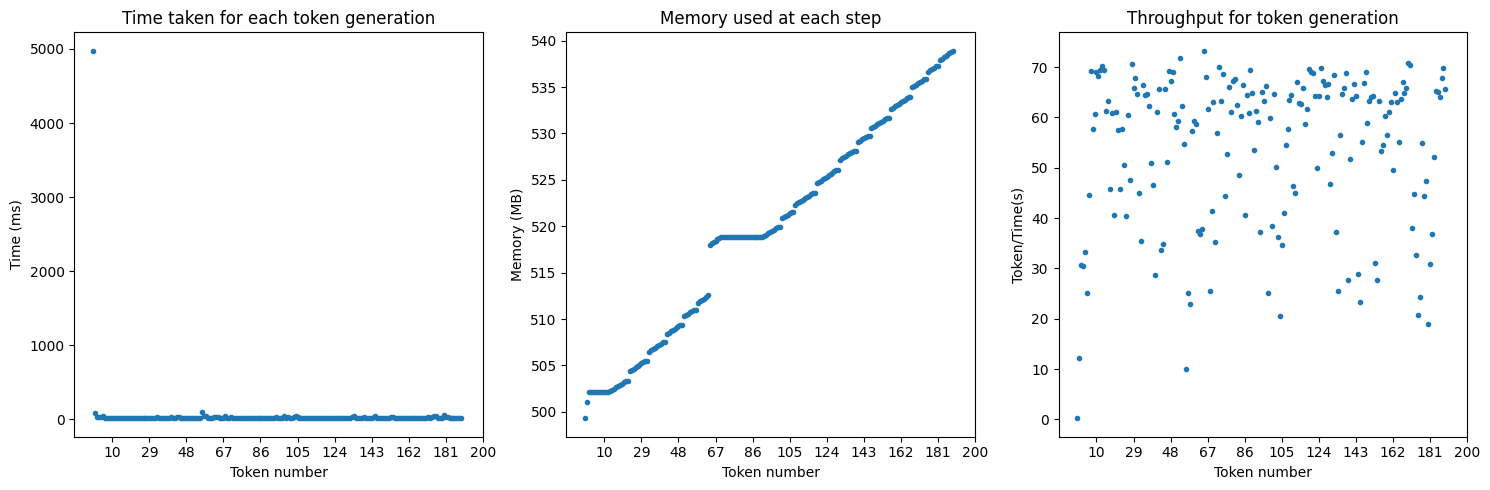

In [5]:
plt.figure(figsize=(15, 5))
x = range(start_step, start_step + len(time_taken_b)+1, (len(time_taken_b)+9)//10)

ax = plt.subplot(1, 3, 1)
plt.plot(time_taken_b, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Time taken for each token generation")
plt.xlabel("Token number")
plt.ylabel("Time (ms)")

ax = plt.subplot(1, 3, 2)
plt.plot(memory_used_b, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Memory used at each step")
plt.xlabel("Token number")
plt.ylabel("Memory (MB)")

ax = plt.subplot(1, 3, 3)
plt.plot(through_b, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Throughput for token generation")
plt.xlabel("Token number")
plt.ylabel("Token/Time(s)")

plt.tight_layout()
plt.show()

**Explaining Plots**:

- ***Memory Usage***: In general, we can see that memory usage increases as we generate more tokens. This is expected because the model needs to store more information as it generates more tokens. The memory usage increases almost linearly with the number of tokens generated. For generating each new token, the model has to process and store more information about the previous context, also, it needs more iteration to each the place of the new token that is wants to generate.
- ***Time Taken***: The time taken for generating each new token is relatively constant. This is because the model processes each token independently and doesn't have to consider the entire sequence when generating a new token.(I'm not sure about this)

**Contrasting:**

- ***Memory Usage***: in part (b), by using `past_key_values` and employing a somehow caching mecanism, memory usage has reduced about *200 (MB)* thats due to avoiding repeated computation for generating each new token.

- ***Time Taken***: Time taken (throughput) is almost the same for both, but part (b) has a little higher throughput, as it avoids repeating the same computation for generating each new token.

## Section 2: Batch Generation (25 points)
Write 4 prompts (a list of 4 sentences). All the sentences you write should have different lengths. Print the input_ids and attention_mask, and explain why the attention_masks are the way they are. When you tokenize, use left-side padding. Explain why left-side padding is preferable during inference. What is the padding token ID in this particular tokenizer?
(10 points)

In [3]:
prompts = [
    "Could you explain how carbon dioxide is produced?",
    "Are you one of the causes of global warming?",
    "My name is Pouya and I'm a student at the University of Tehran.",
    "You are one of the most powerful LLMs I have ever seen!"
]
str_template = """\
Prompt        : {prompt}
Tokens        : {tokens_str}
Token length  : {len_tokens}
input_ids     : {input_ids}
Attention Mask: {attention_mask}\
"""

MAX_LENGTH = 20
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
# tokenizer.add_special_tokens({'pad_token': '<|PAD|>'})
tokenized_prompts = tokenizer(prompts, padding=True, return_tensors='pt').to("cuda")
# tokenized_prompts = [
#     tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=MAX_LENGTH) for prompt in prompts
# ]

print(f"EoS token id: {tokenizer.eos_token_id}")
print(f"Padding id  : {tokenizer.pad_token_id}\n")

for i, (prompt, tokens, attentions) in enumerate(zip(prompts, tokenized_prompts.input_ids, tokenized_prompts.attention_mask), start=1):
    tokens_str = tokenizer.convert_ids_to_tokens(tokens.squeeze())
    len_tokens = len([t for t in tokens_str if t!=tokenizer.pad_token])
    print(f"\nSample ({i})")
    print(
        str_template.format(
            prompt=prompt,
            tokens_str=tokens_str,
            len_tokens=len_tokens,
            input_ids=tokens,
            attention_mask=attentions
            )
        )


EoS token id: 50256
Padding id  : 50256


Sample (1)
Prompt        : Could you explain how carbon dioxide is produced?
Tokens        : ['<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', 'Could', 'Ġyou', 'Ġexplain', 'Ġhow', 'Ġcarbon', 'Ġdioxide', 'Ġis', 'Ġproduced', '?']
Token length  : 9
input_ids     : tensor([50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 23722,   345,
         4727,   703,  6588, 17556,   318,  4635,    30], device='cuda:0')
Attention Mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

Sample (2)
Prompt        : Are you one of the causes of global warming?
Tokens        : ['<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', 'Are', 'Ġyou', 'Ġone', 'Ġof', 'Ġthe', 'Ġcauses', 'Ġof', 'Ġglobal', 'Ġwarming', '?']
Token length  : 10
input_ids     : tensor([50256, 50256, 50256, 50256,

**Explain why the attention_masks are the way they are?**

For processing sequences of varying lengths in a batch or other situations that our inputs should be in an exact size, we often need to pad shorter sequences to match the length of the longest.

For the added pad tokens (we can use both predefined `eos` token or our defined `<|PAD|>` token) the attention mask is set to **0**. Attention mask is a binary sequence, indicates which tokens are actual content and which are paddings and During training, models thought to pay attention only to the non-padding tokens. This means that model won't pay attention to these tokens and they won't have any effect on model's generated output. thsi way we save computation, as paddings don't have any meanings.

As we see, the attention mask is a way to guide model to attent on important inputs.

---
**Why left-side padding is preferable during inference?**

- Left-side padding is preferable during inference because it allows the model to process the input sequence in the same way it was trained. When the model is trained, it learned to predict the next token based on the previous tokens in the sequence. If we use right-side padding during inference, the model will see the padding tokens at the right-most position, trying to predict the next word for that, which can affect the predictions and make it confused. By using left-side padding, we ensure that the model sees the actual input tokens first and can make accurate predictions based on the context. Also, it is meaningless for predict the next token of a <|pad|> token, leading us to place context on the right side of the sequence.
- but why we used padding? we need to use padding (or even truncation) to make different samples in a batch, being at the same size, to prepare them to be fed into the model.
- We need **tokenizer.padding_side = "left"** because we will use the logits of the right-most token to predict the next token, so the padding should be on the left.

---
**What is the padding token ID in this particular tokenizer?**

- if we use the `eos`     token: 50256
- if we use our `<|PAD|>` token: 50258

---


For batch decoding, you should also give position_ids to the model. You should create the position_ids yourself. Explain what position_ids are and how they help. Print the position_ids of your batch prompt. Repeat Section 1, Subsection b, but this time, use the prompt in batch form and give position_ids to the model. Plot the memory needed at each step. Plot the time needed at each step, also plot number of tokens generated per second (a.k.a. throughput). Compare the throughput and memory usage of batch generation with single sentence generation. (15 points)

**Explain what position_ids are and how they help**

They play an important role in handling varying length inputs. We all know about the role of the absolute positional embedding. In normal use case, we don't need to feed positional embeddings as model to assign from 1 to N ti the sequence automatically (regaurdless of anu PAD token, if any). It is clear that this approach had limitations when dealing with variable-length sequences, as we would use PADing tokens. By explicite feeding Posion_ids into model, we ensure that padding tokens have appropriate position IDs, allowing the model to attend correctly during computation. So, position_ids can help model to attent to relevant tokens and ignoring padding tokens and ensuring  accurate modeling of variable-length sequences.

In [4]:
torch.cuda.empty_cache()
model = model.to("cuda")
tokenized_prompts = tokenizer(prompts, padding=True, return_tensors='pt').to("cuda")

position_ids = torch.arange(len(tokenized_prompts["input_ids"][0, :])).unsqueeze(0).to("cuda")
model.config.pad_token_id = tokenizer.pad_token_id

time_taken = []
memory_used = []
throughput = []

tokenized_prompts = tokenizer(prompts, padding=True, return_tensors='pt').to("cuda")
all_tokens = tokenized_prompts["input_ids"]
start_step = len(tokenized_prompts["input_ids"][0,:])

with torch.no_grad():
    past_key_values = None
    for i in range(200-start_step):
        start = time.time()
        outputs = model(
            input_ids=tokenized_prompts["input_ids"],
            attention_mask=tokenized_prompts["attention_mask"],
            position_ids=position_ids,
            past_key_values=past_key_values,
        )
        end = time.time()

        mem_aloc = torch.cuda.max_memory_allocated()
        logits = outputs.logits[:,-1,:]
        next_tokens = logits.argmax(-1)
        past_key_values = outputs.past_key_values

        # print("*"*30)
        # print("next_tokens>>", np.shape(next_tokens))
        # print("all_tokens>>", np.shape(all_tokens))
        # print("input_ids.size>>", tokenized_prompts["input_ids"].size(0))
        # print("attention_mask>>", np.shape(tokenized_prompts["attention_mask"]))
        # print("position_ids>>", np.shape(position_ids))
        all_tokens = torch.cat([all_tokens, next_tokens.unsqueeze(-1)], dim=1)

        position_ids = torch.tensor([position_ids[:, -1:] + 1], device="cuda").unsqueeze(0).to("cuda")
        tokenized_prompts["input_ids"] = next_tokens.unsqueeze(-1)
        tokenized_prompts["attention_mask"] = torch.ones((tokenized_prompts["input_ids"].size(0), 1), device="cuda")

        time_taken.append((end - start) * 1e3)
        memory_used.append(mem_aloc / 1024 / 1024)
        throughput.append(tokenized_prompts["input_ids"].size(0) / (end - start))  # Tokens generated per second (throughput)

for i in range(all_tokens.size(0)):
  generated_sentence = tokenizer.decode(all_tokens[i].squeeze())
  print(f"({i+1})  Generated sentence: {generated_sentence}")
print(f"\nThroughput: {np.mean(throughput)}")

(1)  Generated sentence: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Could you explain how carbon dioxide is produced??
The following is a.
The following is a.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.

The following is a list of the most common ways to get a job.
(2)  Generated sentence: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Are you one of the causes of globa

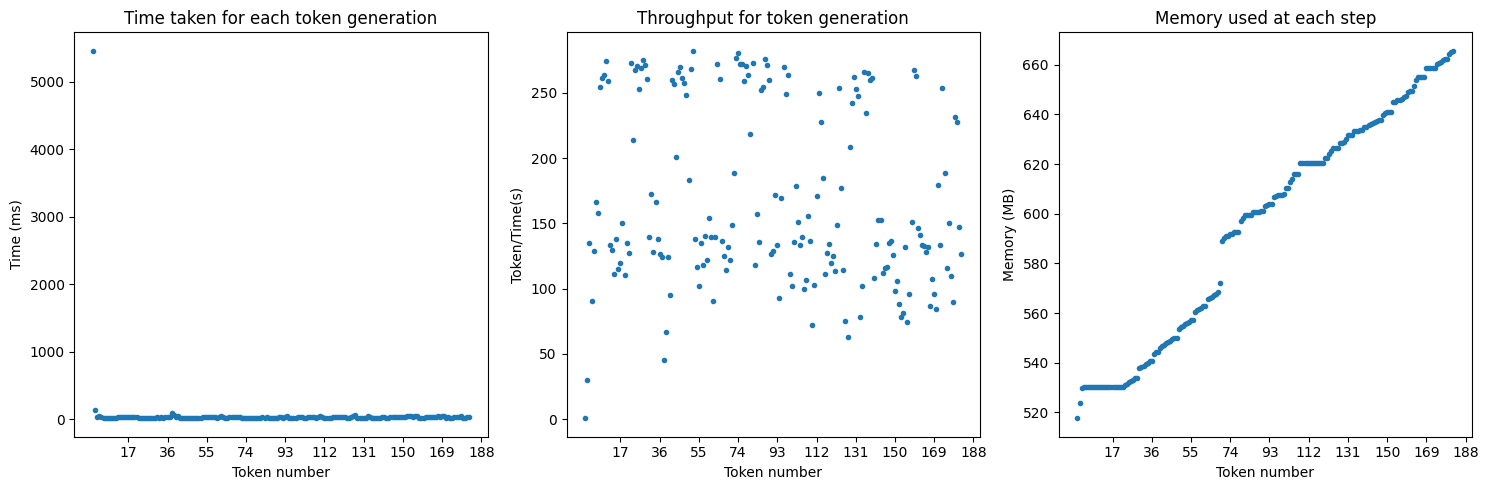

In [5]:
plt.figure(figsize=(15, 5))
x = range(start_step, start_step + len(time_taken)+1, (len(time_taken)+9)//10)

ax = plt.subplot(1, 3, 1)
plt.plot(time_taken, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Time taken for each token generation")
plt.xlabel("Token number")
plt.ylabel("Time (ms)")

ax = plt.subplot(1, 3, 2)
plt.plot(throughput, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Throughput for token generation")
plt.xlabel("Token number")
plt.ylabel("Token/Time(s)")

ax = plt.subplot(1, 3, 3)
plt.plot(memory_used, marker=".", linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title("Memory used at each step")
plt.xlabel("Token number")
plt.ylabel("Memory (MB)")

plt.tight_layout()
plt.show()

**Compare the throughput and memory usage of batch generation with single sentence generation**

- **throughput:** As we expected, Batch Generation were able to achieve higher throughput, both in maximum and in average.

|Generation Method|Mean throughput|Max throughput|
|--|--|--|
|Single Sentence|54|70|
|Batch|168|270|

- **memory usage:** Memory usage is higher in batch generation (660 vs. 540). This happened due to generating multiple sequences, which would result to a higher memory usage. But if we normalize memory overhead, for per sequence generation, then we sees that Batch Generation can better utilize memory (if we have enough to fit in):
  - Single Sentence Generation: $\frac{540 - 500}{1} = 40$
  - Batch Generation: $\frac{660-520}{4} = 35$

